In [1]:
%matplotlib inline
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1) Understanding the Data

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()
print(f"The dimensions of the training set are {train_data.shape}")

The dimensions of the training set are (891, 12)


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_data.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# 2) Feature Selection
Age, Fare, Sex (hot-encoded value), Engineered Title (hot-encoded value), Pclass, Sibsp, Parch 

In [6]:
# import again to ensure stable testing
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')

# drop irrelevant columns and fill NaN age with average
def drop_irrev_col(df):
    # change index
    df.set_index('PassengerId',inplace=True)
    # drop some irrelevant features
    df.drop(['Ticket', 'Cabin','Embarked'], axis=1, inplace=True)
    # fill NaN age with average
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    return df

def feature_engineering(df):
    # RegEx to extract titles and print them
    #df['Title'] = df['Name'].str.extract(r'(\w+)(?=\.)')
    #if(df.Title.isnull().sum()!=0):
    #    warnings.warn("NaN values are found in Titles. Fix before moving on.")
    #print(f"Titles found are {df.Title.unique()}")
    df.drop('Name', axis=1, inplace=True)
    # one-hot encode sex and titles
    #df_new = pd.get_dummies(df, columns=['Sex','Title'],dtype=int)
    df_new = pd.get_dummies(df, columns=['Sex'],dtype=int)
    return df_new

# separate the training set into features dataframe and target data series
def features_and_target(df):
    # everything but survived is a feature
    features = [i for i in df.columns.tolist() if i!= 'Survived']
    X = df[features]
    # binary target
    if 'Survived' in df.columns:
        Y = df['Survived']
    else:
        Y = None
    return X, Y, features

# clean the data
clean_train_data = drop_irrev_col(train_data)
clean_train_data = feature_engineering(clean_train_data)
# separate features and targets
X_clean, y_clean, features = features_and_target(clean_train_data)

In [7]:
X_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Sex_female  891 non-null    int64  
 6   Sex_male    891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 55.7 KB


In [8]:
y_clean.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [9]:
RAND_STAT = 10
X_train, X_cv, y_train, y_cv = train_test_split(X_clean, y_clean, train_size = 0.8, random_state = RAND_STAT)


In [10]:
print(f'train samples: {len(X_train)}\ntest samples: {len(X_cv)}')


train samples: 712
test samples: 179


# 3) Choosing the Model
- Let's test different depths and min_samples_split to see which ones have the best accuracy on the cross validation test and choose the optimal params for our model

In [11]:
#
min_samples_split_list = [2, 5, 10, 30, 40, 50, 60] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1, 2, 3, 4, 8, 10, 16, 32, 64, None] # None means that there is no depth limit.

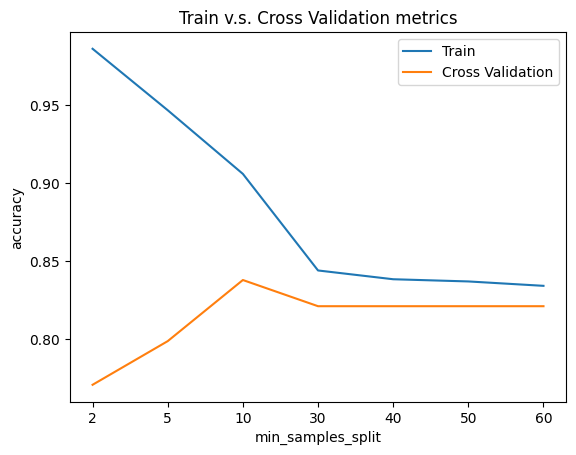

In [12]:
accuracy_list_train = []
accuracy_list_cv = []
for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RAND_STAT).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_cv = model.predict(X_cv) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_cv = accuracy_score(predictions_cv,y_cv)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_cv.append(accuracy_cv)

plt.title('Train v.s. Cross Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_cv)
plt.legend(['Train','Cross Validation'])

In [13]:
# min_samples_split is the sweet spot. min_samples_split > 30 gives a high bias 
# while <30 gives high variance
best_min_samples_split = 30

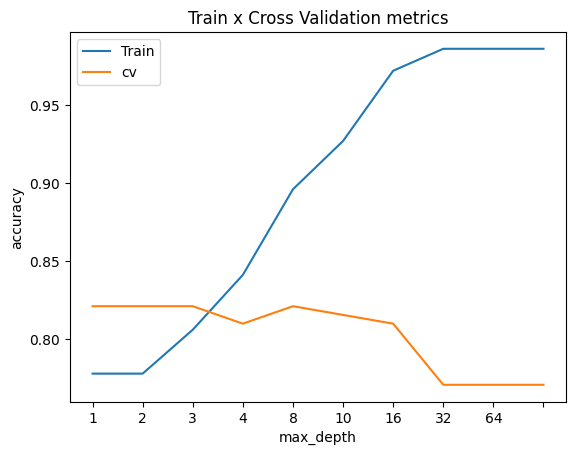

In [14]:
accuracy_list_train = []
accuracy_list_cv = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RAND_STAT).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_cv = model.predict(X_cv) ## The predicted values for the cv dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_cv = accuracy_score(predictions_cv,y_cv)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_cv.append(accuracy_cv)

plt.title('Train x Cross Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_cv)
plt.legend(['Train','cv'])

In [15]:
# maximum cv accuracy reached at max_depth = 8
best_max_depth = 8

# 4) Building the Model

In [16]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = best_min_samples_split,
                                             max_depth = best_max_depth,
                                             random_state = RAND_STAT).fit(X_cv,y_cv)

In [17]:
# How does the model perform on training and cross-validation?
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}\nMetrics cross-validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_cv),y_cv):.2f}")

Metrics train:
	Accuracy score: 0.7458
Metrics cross-validation:
	Accuracy score: 0.88


# 5) Inference

- Import the test dataset
- Prepare it in the same way
- Carry out inference

In [18]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [20]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [21]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [22]:
# clean the data
clean_test_data = drop_irrev_col(test_data)
clean_test_data = feature_engineering(clean_test_data)
# separate features and targets
X_test, y_test, features = features_and_target(clean_test_data)
X_test['Fare'].fillna(X_test['Fare'].median(), inplace=True)

In [23]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        418 non-null    float64
 5   Sex_female  418 non-null    int64  
 6   Sex_male    418 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 26.1 KB


In [24]:
X_test.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
dtype: int64

In [25]:
predictions = decision_tree_model.predict(X_test)

In [26]:
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
output.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [27]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
